In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import cv2
import os
import pydicom
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import albumentations as A
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import precision_score, recall_score, f1_score
# from tqdm.notebook import tqdm

# Config

In [2]:
# Hyperparameters
BATCH_SIZE = 4
N_EPOCHS = 1
PATIENCE = 3
AUGMENTATIONS = True
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_S_Weights.DEFAULT
N_FOLDS = 5
FOLD = 2  
IMG_SIZE = (256,256)

# Scheduler
MAX_LR = 0.0005
MIN_LR = 0.000005
GAMMA = 0.5

# Data

### Load tables

In [3]:
# Load tables
train = pd.read_csv("../Data/train.csv")

# Print dataframe shapes
print('train shape:', train.shape)
print('')

train.head(3)

train shape: (2019, 9)



,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0


### Slice dataframe with vertebrae predictions

In [4]:
train_df_slices = pd.read_csv('./train_segmented.csv')
c1c7 = [f'C{i}' for i in range(1,8)]
train_df_slices[c1c7] = (train_df_slices[c1c7] > 0.5).astype(int)

# Merge dfs
train_df = train_df_slices.set_index('StudyInstanceUID').join(train.set_index('StudyInstanceUID'), rsuffix='_fracture').reset_index().copy()
train_df.head(3)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,...,C6,C7,patient_overall,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032,0,0,...,0,0,0,0,0,0,0,0,0,0


### Droping bad scans

In [5]:
# https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/344862
bad_scans = ['1.2.826.0.1.3680043.20574','1.2.826.0.1.3680043.29952']

for uid in bad_scans:
    train.drop(train[train['StudyInstanceUID']==uid].index, axis=0, inplace=True)
    train_df.drop(train_df[train_df['StudyInstanceUID']==uid].index, axis=0, inplace=True)

### Feature engineering

In [6]:
# Calculate slice ratio
slice_max = train_df.groupby('StudyInstanceUID')['Slice'].max().to_dict()
train_df['SliceRatio'] = 0
train_df['SliceRatio'] = train_df['Slice']/train_df['StudyInstanceUID'].map(slice_max)

# Number of slices
train_df['SliceTotal'] = 0
train_df['SliceTotal'] = train_df['StudyInstanceUID'].map(slice_max)

# Reversed indicator
z_reversed = ((train_df.groupby('StudyInstanceUID')['ImagePositionPatient_z'].first()-train_df.groupby('StudyInstanceUID')['ImagePositionPatient_z'].last())<0).astype('int')
train_df['Reversed'] = 0
train_df['Reversed'] = train_df['StudyInstanceUID'].map(z_reversed)

# Helper functions

In [8]:
def load_dicom(path):
    
    img = pydicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

# Augmentations

In [9]:
# Data augmentations
if AUGMENTATIONS:
    augs = A.Compose([
        A.Resize(*IMG_SIZE, interpolation=cv2.INTER_LINEAR),
        A.HorizontalFlip(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=30, border_mode=cv2.BORDER_CONSTANT, value=0., p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.3),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=25, border_mode=cv2.BORDER_CONSTANT, value=0., p=1.0)
        ], p=0.1),
        ], p=1.0)
else:
    augs = A.Resize(*IMG_SIZE, interpolation=cv2.INTER_LINEAR)

### Visualise augmentations

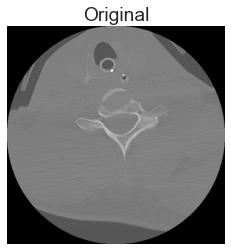

In [10]:
if AUGMENTATIONS:
    path = '../Data/train_images/1.2.826.0.1.3680043.10515/220.dcm'
    img, _ = load_dicom(path)
    plt.imshow(img, cmap='bone')
    plt.axis('off')
    plt.title('Original')
    plt.show()

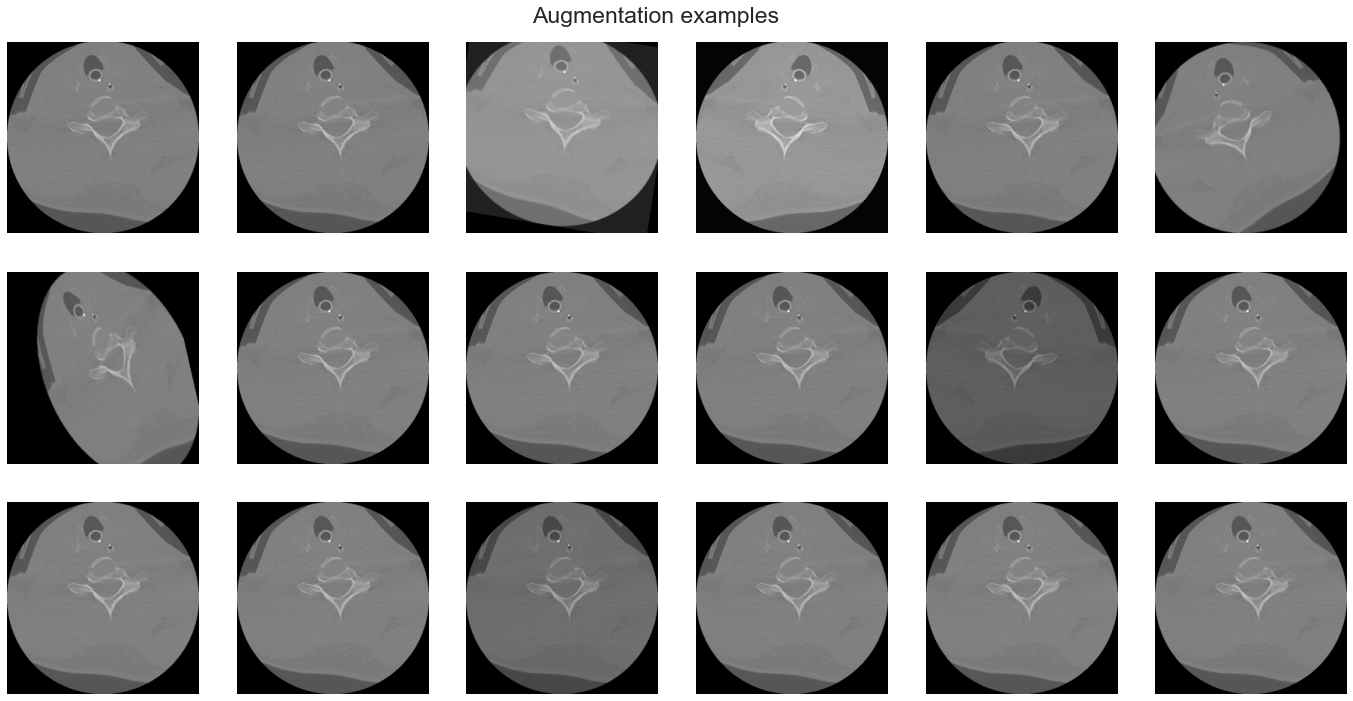

In [11]:
if AUGMENTATIONS:
    
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
    plt.suptitle('Augmentation examples', y=0.92)
    for i in range(18):
        aug_img = augs(image=img)['image']

        x = i // 6
        y = i % 6
        axes[x, y].imshow(aug_img, cmap="bone")
        axes[x, y].axis('off')

# Torch dataset

In [12]:
# Dataset for train/valid sets only
class RSNADataset(Dataset):
    # Initialise
    def __init__(self, df_table = train_df, transform=None):
        super().__init__()
        self.df_table = df_table.reset_index(drop=True)
        self.transform = transform
        self.train_path = '../Data/train_images'
        self.meta_cols = ['SliceRatio','SliceTotal','SliceThickness','ImagePositionPatient_x','ImagePositionPatient_y','ImagePositionPatient_z','Reversed']
        

    def __getitem__(self, index):
        # Load image
        path = os.path.join(self.train_path, self.df_table.iloc[index].StudyInstanceUID, f'{self.df_table.iloc[index].Slice}.dcm')
        img = load_dicom(path)[0]
        
        # Data augmentations
        if self.transform is not None:
            img = self.transform(image=img)['image']
        
        # As Pytorch uses (batch, channel, height, width) order. Converting (height, width, channel) -> (channel, height, width)
        img = np.transpose(img, (2, 0, 1))
        
        # Convert to tensor
        img = torch.from_numpy(img.astype('float32'))
        
        # Targets
        frac_targets = torch.as_tensor(self.df_table.iloc[index][[f'C{i}_fracture' for i in range(1,8)]].astype('float32').values)
        vert_targets = torch.as_tensor(self.df_table.iloc[index][[f'C{i}' for i in range(1,8)]].astype('float32').values)
        frac_targets = frac_targets * vert_targets  # Enable targets that are visible on the current slice
        
        # Metadata
        meta = torch.as_tensor(self.df_table.iloc[index][self.meta_cols].astype('float32').values)
        
        return img, meta, frac_targets, vert_targets

    # Length of dataset
    def __len__(self):
        return len(self.df_table)

In [13]:
train_patients, valid_patients = train_test_split(train['StudyInstanceUID'].values, train_size=0.08, test_size=0.02, random_state=0)
    
# Select train/valid tables
train_table = train_df[train_df['StudyInstanceUID'].isin(train_patients)]
valid_table = train_df[train_df['StudyInstanceUID'].isin(valid_patients)]
    
# Define train/valid dataset
train_dataset = RSNADataset(df_table = train_table, transform=augs)
valid_dataset = RSNADataset(df_table = valid_table, transform=None)

# Torch dataloaders

In [14]:
# Dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model

In [15]:
class ImageMetaModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Image model layers
        effnet = tv.models.efficientnet_v2_s(weights=WEIGHTS)
        self.effnet = create_feature_extractor(effnet, ['flatten'])
        self.img_linear = nn.Linear(1280, 64)
        self.swish = nn.SiLU()
        
        # Metadata model layers
        self.tab_linear1 = nn.Linear(7, 128)
        self.tab_linear2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        
        # Combined model layers
        self.drop = nn.Dropout(p=0.3)
        self.linear1 = nn.Linear(128, 256)
        self.linear2 = nn.Linear(256, 7)
        self.linear3 = nn.Linear(256, 7)
        
        
    # Forward pass
    def forward(self, img, meta):
        # Image model
        x_img = self.effnet(img)['flatten']
        x_img = self.img_linear(x_img)
        x_img = self.swish(x_img)
        
        # Metadata model
        x_meta = self.tab_linear1(meta)
        x_meta = self.relu(x_meta)
        x_meta = self.tab_linear2(x_meta)
        x_meta = self.relu(x_meta)
        
        # Concatenate
        x = torch.cat([x_img, x_meta], dim=1)
        
        # Combined model
        x = self.drop(x)
        x = self.linear1(x)
        x = self.relu(x)
        
        # Split
        x_frac = self.linear2(x)
        x_vert = self.linear3(x)
        
        return x_frac, x_vert

    def predict(self, img, meta):
        frac, vert = self.forward(img, meta)
        return torch.sigmoid(frac), torch.sigmoid(vert)

model = ImageMetaModel()

# Loss & optimiser

In [16]:
loss_fn = nn.BCELoss(reduction='none')

competition_weights = {
    '-' : torch.tensor([1, 1, 1, 1, 1, 1, 1], dtype=torch.float),
    '+' : torch.tensor([2, 2, 2, 2, 2, 2, 2], dtype=torch.float),
}

def FracLoss(y_hat, y):

    loss = loss_fn(y_hat, y.to(y_hat.dtype))
    weights = y * competition_weights['+'] + (1 - y) * competition_weights['-']
    return (loss * weights).sum(axis=1)
    
def VertLoss(y_hat, y):

    loss = loss_fn(y_hat, y.to(y_hat.dtype))
    return loss.sum(axis=1)

def CombinedLoss(y_hat_frac, y_frac, y_hat_vert, y_vert):
    
    # Loss for fracture detection
    L1 = FracLoss(y_hat_frac, y_frac)
    
    # Loss for vertebrae detection
    L2 = VertLoss(y_hat_vert, y_vert)
    
    return (L1+L2).mean()

In [17]:
# AdamW optimiser
optimiser = optim.AdamW(params=model.parameters(), lr=MIN_LR)
    
# https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup
scheduler = CosineAnnealingWarmupRestarts(optimiser,
                                          first_cycle_steps=len(train_loader),
                                          cycle_mult=1.0,
                                          max_lr=MAX_LR,
                                          min_lr=MIN_LR,
                                          warmup_steps=len(train_loader)/20,
                                          gamma=GAMMA)

### Visualise learning rate schedule

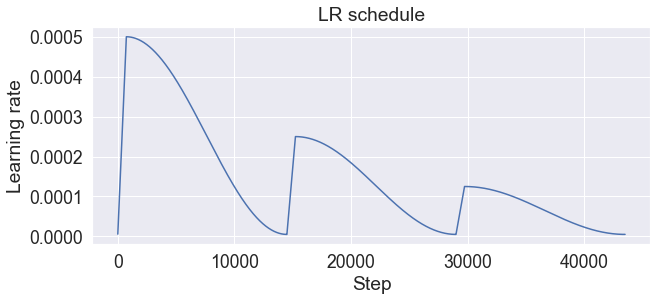

In [18]:
def plot_schedule():
    opt = optim.AdamW(params=model.parameters(), lr=MIN_LR)
    sch = CosineAnnealingWarmupRestarts(opt,
                                          first_cycle_steps=len(train_loader),
                                          cycle_mult=1.0,
                                          max_lr=MAX_LR,
                                          min_lr=MIN_LR,
                                          warmup_steps=len(train_loader)/20,
                                          gamma=GAMMA)
    
    lr_hist = []
    for i in range(3*len(train_loader)):
        sch.step()
        lr_hist.append(opt.param_groups[0]['lr'])
    
    plt.figure(figsize=(10,4))
    plt.plot(lr_hist)
    plt.title('LR schedule')
    plt.xlabel('Step')
    plt.ylabel('Learning rate')
    plt.show()
    
plot_schedule()

# Train model


In [28]:
loss_hist = []
loss_step_hist = []

# Loop over epochs
for epoch in tqdm(range(N_EPOCHS)):
    loss_acc = 0
    loss_step = 0
    
    # Loop over batches
    for idx, (img, meta, frac_targets, vert_targets) in enumerate(train_loader):
        
        # Forward pass
        frac_preds, vert_preds = model(img, meta)
        L = CombinedLoss(frac_preds, frac_targets, vert_preds, vert_targets)

        # Backprop
        L.backward()

        # Update parameters
        optimiser.step()

        # Zero gradients
        optimiser.zero_grad()
        
        # Track loss
        loss_step += L.detach().item()
    
        # Update learning rate
        scheduler.step()
        
        # Print progress
        if (idx%1000)==0:
            loss_acc += loss_step
            print(f'Minibatch iteration: {idx}/{len(train_loader)}, Loss: {loss_step/1000:.8f}')
            
            # Save loss history
            loss_step_hist.append(loss_step/1000)
            
            # Reset
            loss_step = 0
    
    
    # Save loss history
    loss_hist.append(loss_acc/len(train_loader))
    
    # Print loss
    print(f'Epoch {epoch+1}/{N_EPOCHS}, loss {loss_acc/len(train_loader):.8f}')
    
    # Save model
    print('Saving model')
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimiser_state_dict': optimiser.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss_acc/len(train_loader),
        }, f"EffNet_model_fold{FOLD}_epoch{epoch+1}.pt")
    
print('')
print('Training complete!')

  0%|          | 0/1 [00:00<?, ?it/s]

Minibatch iteration: 0/14505, Loss: 0.09031808


KeyboardInterrupt: 

### Learning curves

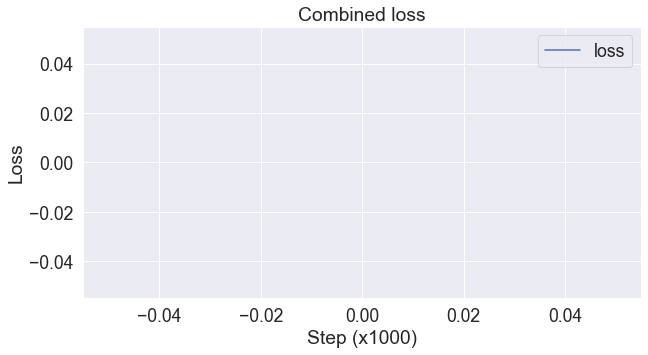

In [29]:
# Plot loss every 1000 minibatches
plt.figure(figsize=(10,5))
plt.plot(loss_step_hist[1:], c='C0', label='loss')
plt.title('Combined loss')
plt.xlabel('Step (x1000)')
plt.ylabel('Loss')
plt.legend()
plt.show()

Load Model

In [19]:
# Load checkpoint
PATH='./Effnet_model.pt'
checkpoint = torch.load(PATH,map_location=torch.device('cpu'))

# Load states
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Evaluation mode
model.eval()
print('')

In [20]:
def get_predictions(model, data_loader):
    
    val_loss = 0
    with torch.no_grad():
        predictions = []
        for idx, (img, meta, frac_targets, vert_targets) in enumerate(tqdm(data_loader)):
            y1, y2 = model.predict(img, meta)
            
            # Validation loss
            L = CombinedLoss(y1, frac_targets, y2, vert_targets)
            val_loss += L.detach().item()
            
            # Save predictions
            pred = torch.cat([y1, y2], dim=1)
            predictions.append(pred)
            
            # Print iteration
            if (idx%1000)==0:
                print(f'Minibatch iteration {idx}/{len(data_loader)}')
        
        print('Combined validation loss:', val_loss/len(data_loader))
        
        return torch.cat(predictions).cpu().numpy()

In [23]:
preds = get_predictions(model, valid_loader)

  0%|          | 0/3492 [00:00<?, ?it/s]

Minibatch iteration 0/3492
Minibatch iteration 1000/3492
Minibatch iteration 2000/3492
Minibatch iteration 3000/3492
Combined validation loss: 2.589253389230158


AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [93]:
preds_df=pd.DataFrame(preds)
preds_df.head()
preds_df.to_csv('preds.csv',index=False)

In [95]:
# preds=pd.read_csv('./preds.csv')
df_preds = pd.DataFrame(data=preds, columns=[f'C{i}_frac' for i in range(1, 8)] + [f'C{i}_vert' for i in range(1, 8)])
df_preds_concat = pd.concat([valid_table.reset_index(drop=True).loc[:,['StudyInstanceUID','Slice']], df_preds], axis=1)
df_preds_concat.to_csv('conc_predictions.csv', index=False)
df_preds_concat.head(3)

,StudyInstanceUID,Slice,C1_frac,C2_frac,C3_frac,C4_frac,C5_frac,C6_frac,C7_frac,C1_vert,C2_vert,C3_vert,C4_vert,C5_vert,C6_vert,C7_vert
0,1.2.826.0.1.3680043.10400,1,0.014173,0.009084,0.002362,0.000638,0.000173,0.001894,0.004219,0.032238,0.155026,0.030057,0.003104,0.000163,0.000190,0.006669
1,1.2.826.0.1.3680043.10400,2,0.014639,0.009027,0.002522,0.000701,0.000164,0.001641,0.004120,0.034664,0.156385,0.036934,0.003429,0.000138,0.000136,0.006314
2,1.2.826.0.1.3680043.10400,3,0.013995,0.009461,0.002527,0.000636,0.000163,0.001708,0.004340,0.025799,0.138008,0.042470,0.003329,0.000129,0.000160,0.007165


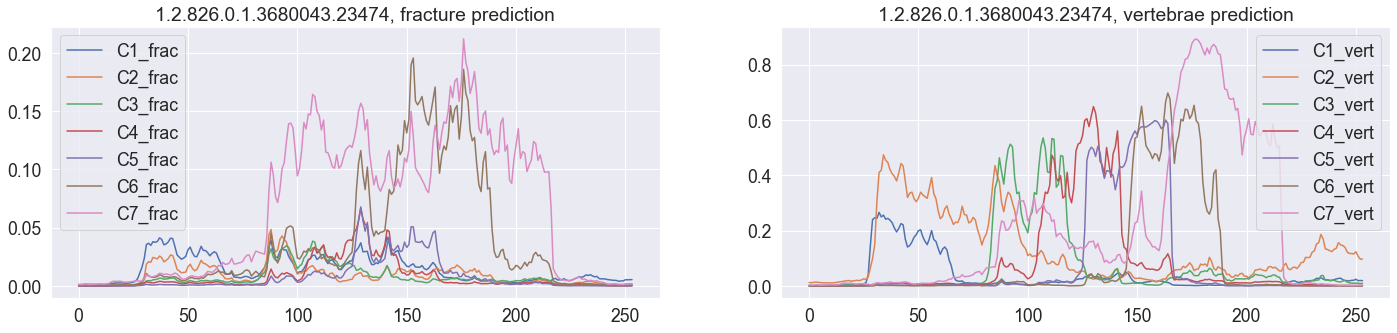

In [28]:
patient = np.random.choice(valid_table.query('patient_overall > 0').StudyInstanceUID)
def plot_sample_patient(df_pred, patient):
    df = df_pred.query('StudyInstanceUID == @patient').reset_index(drop=True)
    
    plt.figure(figsize=(24,5))
    df[[f'C{i}_frac' for i in range(1, 8)]].plot(
        title=f'{patient}, fracture prediction',
        ax=(plt.subplot(1, 2, 1)))
    
    df[[f'C{i}_vert' for i in range(1, 8)]].plot(
        title=f'{patient}, vertebrae prediction',
        ax=plt.subplot(1, 2, 2)
    )

plot_sample_patient(df_preds_concat, patient)

In [29]:
train_df[train_df['StudyInstanceUID']==patient]

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,...,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture,SliceRatio,SliceTotal,Reversed
326040,1.2.826.0.1.3680043.23474,1,512,512,0.625,-130.5,-136.0,7.000,0,0,...,0,0,0,0,0,1,0,0.003937,254,0
326041,1.2.826.0.1.3680043.23474,2,512,512,0.625,-130.5,-136.0,6.375,0,0,...,0,0,0,0,0,1,0,0.007874,254,0
326042,1.2.826.0.1.3680043.23474,3,512,512,0.625,-130.5,-136.0,5.750,0,0,...,0,0,0,0,0,1,0,0.011811,254,0
326043,1.2.826.0.1.3680043.23474,4,512,512,0.625,-130.5,-136.0,5.125,0,0,...,0,0,0,0,0,1,0,0.015748,254,0
326044,1.2.826.0.1.3680043.23474,5,512,512,0.625,-130.5,-136.0,4.500,0,0,...,0,0,0,0,0,1,0,0.019685,254,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326289,1.2.826.0.1.3680043.23474,250,512,512,0.625,-130.5,-136.0,-148.625,0,0,...,0,0,0,0,0,1,0,0.984252,254,0
326290,1.2.826.0.1.3680043.23474,251,512,512,0.625,-130.5,-136.0,-149.250,0,0,...,0,0,0,0,0,1,0,0.988189,254,0
326291,1.2.826.0.1.3680043.23474,252,512,512,0.625,-130.5,-136.0,-149.875,0,0,...,0,0,0,0,0,1,0,0.992126,254,0
326292,1.2.826.0.1.3680043.23474,253,512,512,0.625,-130.5,-136.0,-150.500,0,0,...,0,0,0,0,0,1,0,0.996063,254,0


In [7]:
def patient_prediction(df):
    c1c7 = np.average(df[[f'C{i}_frac' for i in range(1, 8)]].values, axis=0, weights=df[[f'C{i}_vert' for i in range(1, 8)]].values)
    pred_patient_overall = 1 - np.prod(1 - c1c7)
    return pd.Series(data=np.concatenate([[pred_patient_overall], c1c7]), index=['patient_overall'] + [f'C{i}' for i in range(1, 8)])

In [8]:
def max_to_one(row):
    max_val = row[2:].max()
    return [1 if x == max_val else 0 for x in row]

In [9]:
df_preds_concat=pd.read_csv('./conc_predictions.csv')
df_patient_pred = df_preds_concat.groupby('StudyInstanceUID').apply(lambda df: patient_prediction(df))

# Apply function to each row
df_patient_pred = df_patient_pred.apply(max_to_one, axis=1, result_type='broadcast')
df_patient_pred['patient_overall']=1.0

df_patient_pred.reset_index(inplace=True) 
df_patient_pred.rename(columns={'index': 'StudyInstanceUID'}, inplace=True) 

df_patient_pred.to_csv('predictions.csv', index=False)
df_patient_pred.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10400,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.2.826.0.1.3680043.10579,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.2.826.0.1.3680043.10628,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.2.826.0.1.3680043.10678,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.2.826.0.1.3680043.11384,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
def calculate_columnwise_accuracy(df1, df2):
    column_accuracies = []
    total_columns = len(df1.columns[2:7])

    for column in df1.columns[2:9]:

        matching_count = sum(df1[column] == df2[column])
        accuracy = matching_count / len(df1)
        column_accuracies.append(accuracy)

    average_accuracy = sum(column_accuracies[0:5]) / total_columns

    return column_accuracies, average_accuracy

def calculate_metrics(y_test,df_patient_pred):
    precision_list = []
    recall_list = []
    f1_list = []

    # Calculate metrics for each column pair
    for col in y_test.columns[2:]:
        actual_col = y_test[col]
        predicted_col = df_patient_pred[col]
        
        precision = precision_score(actual_col, predicted_col,average=None)
        recall = recall_score(actual_col, predicted_col,average=None)
        f1 = f1_score(actual_col, predicted_col,average=None)
        
        precision_list.append(precision[0])
        recall_list.append(recall[0])
        f1_list.append(f1[0])

    df_res = []

    for i in range(len(y_test.columns[2:])):
        df_res.append([y_test.columns[2:][i], recall_list[i], precision_list[i], f1_list[i]])
    df_res = pd.DataFrame(df_res, columns = ['Class','Precision','Recall', 'F1-score'])
    
    return df_res

In [23]:
y_test = train.merge(df_patient_pred.reset_index()['StudyInstanceUID'], how='right', on='StudyInstanceUID')

column_accuracies, average_accuracy = calculate_columnwise_accuracy(df_patient_pred, y_test)
print("Column-wise accuracies:", column_accuracies)
print("Average accuracy:", average_accuracy)
print(calculate_metrics(y_test,df_patient_pred))

Column-wise accuracies: [0.9024390243902439, 0.8780487804878049, 0.926829268292683, 0.9024390243902439, 0.9512195121951219, 0.43902439024390244, 0.6097560975609756]
Average accuracy: 0.9121951219512194
  Class  Precision    Recall  F1-score
0    C1   1.000000  0.902439  0.948718
1    C2   0.972973  0.900000  0.935065
2    C3   1.000000  0.926829  0.962025
3    C4   1.000000  0.902439  0.948718
4    C5   1.000000  0.951220  0.975000
5    C6   0.416667  0.882353  0.566038
6    C7   0.628571  0.880000  0.733333
